# Emotion Classification

**Dataset**: 
- https://huggingface.co/datasets/dair-ai/emotion

In [19]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, TrainingArguments, Trainer, pipeline
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display

In [20]:
pio.renderers.default="notebook"

model_checkpoint = "bert-base-uncased"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
device

device(type='cuda')

### Data Preparation

In [22]:
df = pd.read_parquet("hf://datasets/dair-ai/emotion/unsplit/train-00000-of-00001.parquet")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [24]:
label_name_map = {0:"sadness",
1:"joy",
2:"love",
3:"anger",
4:"fear",
5:"surprise"}

df['label_name'] = df['label'].map(label_name_map)

In [25]:
df.label_name.value_counts(normalize=True).sort_values(ascending=False)

label_name
joy         0.338445
sadness     0.290749
anger       0.137514
fear        0.114470
love        0.082901
surprise    0.035921
Name: proportion, dtype: float64

In [26]:
df.head()

,text,label,label_name
0,i feel awful about it too because it s my job ...,0,sadness
1,im alone i feel awful,0,sadness
2,ive probably mentioned this before but i reall...,1,joy
3,i was feeling a little low few days back,0,sadness
4,i beleive that i am much more sensitive to oth...,2,love


In [9]:
# # save data 
# df.to_csv('./data/twitter_sentiment.csv', index=False)

### Data Exploration

In [27]:
label_counts = df.label_name.value_counts(normalize=True, ascending=True)

In [28]:
label_counts.values

array([0.03592053, 0.08290128, 0.1144697 , 0.13751383, 0.29074948,
       0.33844519])

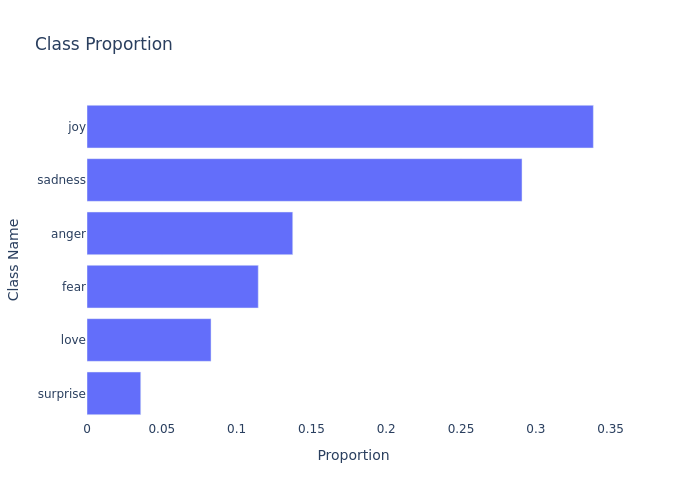

In [35]:
fig = go.Figure()

fig.add_trace(
    go.Bar(orientation="h",
           x=label_counts.values,
           y=label_counts.index
    )
)

fig.update_layout(
    title="Class Proportion",
    xaxis_title="Proportion",
    yaxis_title="Class Name",
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

fig.write_image("./assets/plot1.png")
display(Image("./assets/plot1.png"))

# Uncomment below fig for interactive plot in your local
# fig.show() 

In [31]:
df['words_per_tweet'] = df['text'].str.split().apply(len)

In [32]:
df.head()

,text,label,label_name,words_per_tweet
0,i feel awful about it too because it s my job ...,0,sadness,26
1,im alone i feel awful,0,sadness,5
2,ive probably mentioned this before but i reall...,1,joy,27
3,i was feeling a little low few days back,0,sadness,9
4,i beleive that i am much more sensitive to oth...,2,love,18


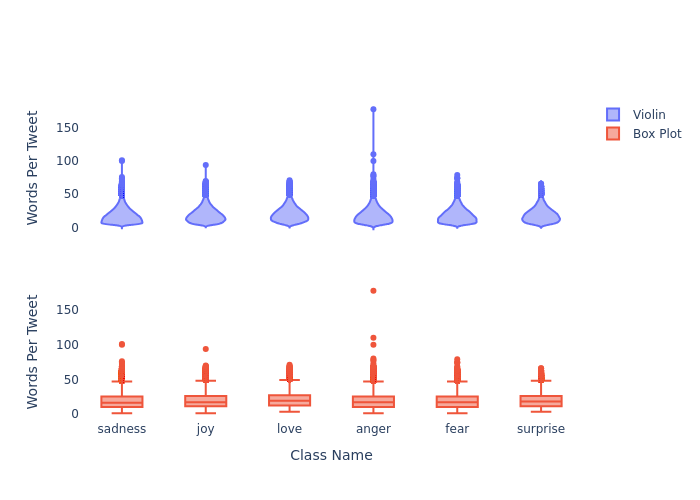

In [36]:
fig = make_subplots(cols=1, rows=2, 
                    shared_xaxes=True, 
                    row_heights=[0.5, 0.5])

fig.add_trace(
    go.Violin(
        x=df.label_name,
        y=df.words_per_tweet,
        name='Violin'
    ), col=1, row=1
)

fig.add_trace(
    go.Box(
        x=df.label_name,
        y=df.words_per_tweet,
        name='Box Plot'
    ), col=1, row=2
)

fig.update_layout(
    height=1000,
    xaxis2_title='Class Name',
    yaxis_title='Words Per Tweet',
    yaxis2_title='Words Per Tweet',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)


fig.write_image("./assets/plot2.png")
display(Image("./assets/plot2.png"))

# Uncomment below fig for interactive plot in your local
# fig.show() 

### Tokenization

In [44]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [45]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [46]:
text = "I love AI! Check tokenization!"

encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 9932, 999, 4638, 19204, 3989, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Special tokens:
- 101 is [CLS]
- 102 is [SEP]

In [47]:
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

### Data Loader and Train Test Split

In [48]:
# convert into Hugging Face dataset
dataset = Dataset.from_pandas(df)
class_names = sorted(set(dataset['label']))
dataset = dataset.cast_column("label", ClassLabel(names=class_names))

Casting the dataset:   0%|          | 0/416809 [00:00<?, ? examples/s]

In [49]:
# split train and test
split_dataset = dataset.train_test_split(test_size=0.3, seed=42, stratify_by_column="label")

# split test and val
split_test_val = split_dataset['test'].train_test_split(test_size=0.3, seed=42, stratify_by_column='label')

In [50]:
split_dataset, split_test_val

(DatasetDict({
     train: Dataset({
         features: ['text', 'label', 'label_name', 'words_per_tweet'],
         num_rows: 291766
     })
     test: Dataset({
         features: ['text', 'label', 'label_name', 'words_per_tweet'],
         num_rows: 125043
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['text', 'label', 'label_name', 'words_per_tweet'],
         num_rows: 87530
     })
     test: Dataset({
         features: ['text', 'label', 'label_name', 'words_per_tweet'],
         num_rows: 37513
     })
 }))

In [51]:
hg_dataset = DatasetDict(
    dict(
        train=split_dataset['train'], # train set
        test=split_test_val['train'], # test set
        val=split_test_val['test'] # val set
    )
)

In [52]:
hg_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 291766
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 87530
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 37513
    })
})

In [53]:
hg_dataset['train'][0], hg_dataset['train'][1]

({'text': 'i feel like johnny cashs voice or maybe just the way he sings is terrible',
  'label': 0,
  'label_name': 'sadness',
  'words_per_tweet': 15},
 {'text': 'i have this stupid feeling were too into the activity since weve devoted so much time to it',
  'label': 2,
  'label_name': 'love',
  'words_per_tweet': 18})

In [54]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

In [55]:
# test tokenizer
print(tokenize(hg_dataset['train'][:2]))

{'input_ids': [[101, 1045, 2514, 2066, 5206, 5356, 2015, 2376, 2030, 2672, 2074, 1996, 2126, 2002, 10955, 2003, 6659, 102, 0, 0, 0], [101, 1045, 2031, 2023, 5236, 3110, 2020, 2205, 2046, 1996, 4023, 2144, 2057, 3726, 7422, 2061, 2172, 2051, 2000, 2009, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [56]:
emotion_encoded = hg_dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/291766 [00:00<?, ? examples/s]

Map:   0%|          | 0/87530 [00:00<?, ? examples/s]

Map:   0%|          | 0/37513 [00:00<?, ? examples/s]

In [57]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 291766
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 87530
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 37513
    })
})

### Map Label to Id and Id to Label

In [58]:
label2id = dict((x['label_name'], x['label']) for x in hg_dataset['train'])

id2label = dict((v,k) for k, v in label2id.items())

In [59]:
label2id, id2label

({'sadness': 0, 'love': 2, 'joy': 1, 'anger': 3, 'fear': 4, 'surprise': 5},
 {0: 'sadness', 2: 'love', 1: 'joy', 3: 'anger', 4: 'fear', 5: 'surprise'})

In [60]:
# Set config
num_labels = len(label2id)
config = AutoConfig.from_pretrained(model_checkpoint, label2id=label2id, id2label=id2label)

### Model Building

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config).to(device)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [34]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### Training Arguments

In [35]:
batch_size = 16
training_dir = "bert_base_uncased_emotion_classification"

training_args = TrainingArguments(output_dir= training_dir,
                                 overwrite_output_dir=True,
                                 num_train_epochs= 2,
                                 learning_rate=5e-05,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 eval_strategy='steps',
                                 disable_tqdm=False,
                                 load_best_model_at_end=True)

### Compute Metrics

In [36]:
target_names = [label_name_map[i] for i in sorted(label_name_map)]
print(target_names)

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [40]:
def compute_metrics(prediction):
    predictions, labels = prediction
    predictions = np.argmax(predictions, axis=1)
    report = classification_report(
        labels,
        predictions,
        target_names=target_names,
        output_dict=True,
        zero_division=0 
    )

    return {
        "accuracy": report["accuracy"],
        "precision_macro": report["weighted avg"]["precision"],
        "recall_macro": report["weighted avg"]["recall"],
        "f1_macro": report["weighted avg"]["f1-score"],
    }

### Model Training

In [41]:
trainer = Trainer(model=model, 
                 args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=emotion_encoded['train'],
                 eval_dataset=emotion_encoded['val'],
                 tokenizer=tokenizer)

/tmp/ipykernel_11639/1658509394.py:1: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [42]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
500,0.196000,0.294190,0.918668,0.924601,0.918668,0.919961
1000,0.241300,0.210450,0.924373,0.926646,0.924373,0.924573
1500,0.179300,0.145727,0.933863,0.938408,0.933863,0.932524
2000,0.146900,0.141704,0.935516,0.944020,0.935516,0.936674
2500,0.151700,0.141105,0.935622,0.939282,0.935622,0.934304
3000,0.143400,0.128941,0.936155,0.938900,0.936155,0.934642
3500,0.150100,0.140122,0.934369,0.937576,0.934369,0.932404
4000,0.145800,0.118557,0.938741,0.941486,0.938741,0.937307
4500,0.115500,0.121801,0.938901,0.947316,0.938901,0.940431
5000,0.140900,0.117556,0.937915,0.941837,0.937915,0.936446


TrainOutput(global_step=36472, training_loss=0.10901750444084647, metrics={'train_runtime': 10784.5608, 'train_samples_per_second': 54.108, 'train_steps_per_second': 3.382, 'total_flos': 3.628563938574379e+16, 'train_loss': 0.10901750444084647, 'epoch': 2.0})

### Model Evaluation

In [ ]:
preds = trainer.predict(emotion_encoded['test'])

In [61]:
y_pred = np.argmax(preds.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [63]:
cls_report = classification_report(y_true, y_pred, target_names=target_names)
print(cls_report)

              precision    recall  f1-score   support

     sadness       1.00      0.96      0.98     25449
         joy       0.92      1.00      0.96     29624
        love       1.00      0.70      0.82      7256
       anger       0.94      0.95      0.95     12037
        fear       0.90      0.91      0.91     10020
    surprise       0.77      0.91      0.83      3144

    accuracy                           0.94     87530
   macro avg       0.92      0.90      0.91     87530
weighted avg       0.95      0.94      0.94     87530



In [101]:
cm = confusion_matrix(y_true, y_pred)

In [103]:
fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        z=cm,
        x=target_names,
        y=target_names,
        colorscale='Blues',
        text=cm,
        texttemplate="%{text}",
        showscale=True
    )
)

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted',
    yaxis_title='Actual'
)

fig.show()

### Save Model

In [117]:
trainer.save_model("./bert_base_uncased_emotion_classification")

### Load Fine-Tuned Model

In [68]:
model_path = "./bert_base_uncased_emotion_classification"
tokenizer_path = "./bert_base_uncased_emotion_classification"

In [69]:
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

In [70]:
tokenizer

BertTokenizerFast(name_or_path='./bert_base_uncased_emotion_classification', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [71]:
model.config

BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [72]:
classifier = pipeline('text-classification', 
                      model=model, 
                      tokenizer=tokenizer)

Device set to use cuda:0


In [77]:
classifier("I love reading books!")

[{'label': 'joy', 'score': 0.6743651032447815}]

In [78]:
model.config.id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [79]:
# or use function
def prediction(input_text):
    encoded_text = tokenizer(input_text, return_tensors="pt").to(device)
    with torch.inference_mode():
        output = model(**encoded_text)
        logits = output.logits
        pred_id = torch.argmax(logits, dim=1).item()
    return model.config.id2label[pred_id]    

In [80]:
prediction("I love reading books!")

'joy'